In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
data = pd.read_csv("/content/HousesInfo.csv")
data.head()

,x1,x2,x3,x4,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [4]:
Y = data["price"].values
print(Y.shape)

(535,)


In [5]:
def combine_images(image_paths):
    images = [Image.open(img).resize((128, 128)) for img in image_paths]

    new_img = Image.new('RGB', (256, 256))

    new_img.paste(images[0], (0, 0))         # بالا چپ
    new_img.paste(images[1], (128, 0))       # بالا راست
    new_img.paste(images[2], (0, 128))       # پایین چپ
    new_img.paste(images[3], (128, 128))     # پایین راست
    new_img = new_img.resize((224, 224))
    return new_img


for i in range(1,536):
  folder = '/content/drive/MyDrive/Houses Dataset'
  house_id = i
  img_paths = [
      os.path.join(folder, f"{house_id}_bathroom.jpg"),
      os.path.join(folder, f"{house_id}_bedroom.jpg"),
      os.path.join(folder, f"{house_id}_frontal.jpg"),
      os.path.join(folder, f"{house_id}_kitchen.jpg"),
  ]

  combined = combine_images(img_paths)
  combined.save(f"/content/drive/MyDrive/Dataset/{house_id}_combined.jpg")


In [35]:
X = []

for image in os.listdir("/content/drive/MyDrive/Dataset"):
  img = cv2.imread("/content/drive/MyDrive/Dataset/" + image)
  X.append(img)

X = np.array(X)
print(X.shape)

(535, 224, 224, 3)


In [36]:
X_train , X_validation , Y_train , Y_validation = train_test_split(X,Y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(428, 224, 224, 3)
(107, 224, 224, 3)
(428,)
(107,)


In [44]:
image_data_generator = ImageDataGenerator(
    rescale=1./255.0,
    horizontal_flip=True,
)

dataset_train = image_data_generator.flow(X_train,Y_train,batch_size=16)
dataset_validation = image_data_generator.flow(X_validation,Y_validation,batch_size=16)

In [45]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights='imagenet',pooling="avg")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [39]:
# for layer in base_model.layers[:-4]:
#   layer.trainable = False

In [46]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="linear")
])

In [47]:
model.compile(optimizer="adam",loss="mae")

In [48]:
history = model.fit(dataset_train , epochs=128 , validation_data=dataset_validation)

Epoch 1/128


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - loss: 605536.6875 - val_loss: 550453.6250
Epoch 2/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 592027.7500 - val_loss: 550619.3125
Epoch 3/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 652033.6250 - val_loss: 551858.3750
Epoch 4/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 589870.3125 - val_loss: 550039.5625
Epoch 5/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 632267.1875 - val_loss: 547136.1875
Epoch 6/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 607941.1875 - val_loss: 528995.1250
Epoch 7/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 559281.5000 - val_loss: 476220.1562
Epoch 8/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 567720.1250 - val_loss: 9715951.0000
Epoch 9/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 529613.8750 - val_loss: 366803.8750
Epoch 10/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - loss: 514234.2188 - val_loss: 4354224.0000
Epoch 11/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 

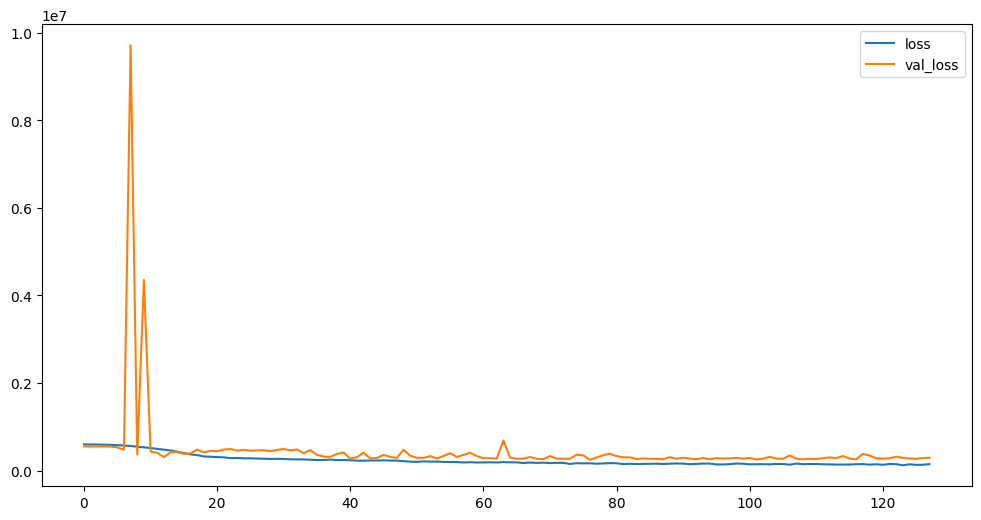

In [49]:
plt.figure(figsize=(12,6))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()
plt.show()